In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.io as sio
import pprint as pp
import numpy as np
import seaborn as sns
import pandas as pd
import os
import re
import gc
# pre
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
# Study
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
import matplotlib as mpl
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
from time import time
from scipy import stats

# helpers files
import infoStructure as ins
import helpers as hp
import display as dp
import clustering as cl
import importlib #importlib.reload(foo)

In [2]:
SMLDDir = '/sanssauvegarde/homes/v18porti/info/Brest_Samples/'
BIGDDir = '/media/v18porti/ADATA SH14/stg/Brest/'
FEATHDir = '/sanssauvegarde/homes/v18porti/info/'
MDIR = BIGDDir

### Get LABELS

In [3]:
#labels = ins.getFirstOneInfo(MDIR + 'RS10001/RS10001_170503_100212.mat')

### Get features info

In [4]:
#t0 = time()
#feat_dict = ins.addAllPatientsInfoV2(MDIR, ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'], 100)
#print("total time:", round(time()-t0, 3), "s")

In [5]:
"""vectorRRKLD_ALL = feat_dict['vectorRRKLD']
vectorFAmpKLD_ALL = feat_dict['vectorFAmpKLD']
vectorUFAmpKLD_ALL = feat_dict['vectorUFAmpKLD']
vectorCorrKLD_ALL = feat_dict['vectorCorrKLD']
del feat_dict
gc.collect()"""

"vectorRRKLD_ALL = feat_dict['vectorRRKLD']\nvectorFAmpKLD_ALL = feat_dict['vectorFAmpKLD']\nvectorUFAmpKLD_ALL = feat_dict['vectorUFAmpKLD']\nvectorCorrKLD_ALL = feat_dict['vectorCorrKLD']\ndel feat_dict\ngc.collect()"

In [6]:
"""print(vectorRRKLD_ALL.shape)
print(vectorFAmpKLD_ALL.shape)
print(vectorUFAmpKLD_ALL.shape)
print(vectorCorrKLD_ALL.shape)"""

'print(vectorRRKLD_ALL.shape)\nprint(vectorFAmpKLD_ALL.shape)\nprint(vectorUFAmpKLD_ALL.shape)\nprint(vectorCorrKLD_ALL.shape)'

### Tranform to a dataframe to be able to work better with it

In [7]:
"""df_ALL = hp.convertDictInDF(hp.putDataInDict(
        [vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL],
        ['vectorRRKLD_ALL', 'vectorFAmpKLD_ALL', 'vectorUFAmpKLD_ALL', 'vectorCorrKLD_ALL']
    ))
del vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL
gc.collect()"""

"df_ALL = hp.convertDictInDF(hp.putDataInDict(\n        [vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL],\n        ['vectorRRKLD_ALL', 'vectorFAmpKLD_ALL', 'vectorUFAmpKLD_ALL', 'vectorCorrKLD_ALL']\n    ))\ndel vectorRRKLD_ALL, vectorFAmpKLD_ALL, vectorUFAmpKLD_ALL, vectorCorrKLD_ALL\ngc.collect()"

In [3]:
df_ALL = pd.read_feather(FEATHDir + '100.feather')

In [4]:
df_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18318591 entries, 0 to 18318590
Data columns (total 4 columns):
vectorRRKLD_ALL       float64
vectorFAmpKLD_ALL     float64
vectorUFAmpKLD_ALL    float64
vectorCorrKLD_ALL     float64
dtypes: float64(4)
memory usage: 559.0 MB


In [5]:
df_ALL.describe()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
count,1.831813e+07,1.831859e+07,1.831859e+07,1.776837e+07
mean,1.161699e+05,6.841581e+01,8.901138e+01,9.737534e+00
std,2.485531e+08,4.143550e+02,4.064917e+02,1.297526e+01
min,-1.196758e+01,0.000000e+00,-1.520206e+00,0.000000e+00
25%,8.495455e+00,3.713773e+00,1.054000e+01,4.394591e+00
50%,1.112204e+01,5.402751e+00,1.454159e+01,7.082061e+00
75%,1.566994e+01,8.439792e+00,2.199167e+01,1.147552e+01
max,5.349180e+11,1.286997e+04,1.465847e+04,7.022134e+02


In [6]:
df_ALL.corr()

,vectorRRKLD_ALL,vectorFAmpKLD_ALL,vectorUFAmpKLD_ALL,vectorCorrKLD_ALL
vectorRRKLD_ALL,1.000000,-0.000071,-0.000037,0.001541
vectorFAmpKLD_ALL,-0.000071,1.000000,0.940104,-0.024814
vectorUFAmpKLD_ALL,-0.000037,0.940104,1.000000,0.009830
vectorCorrKLD_ALL,0.001541,-0.024814,0.009830,1.000000


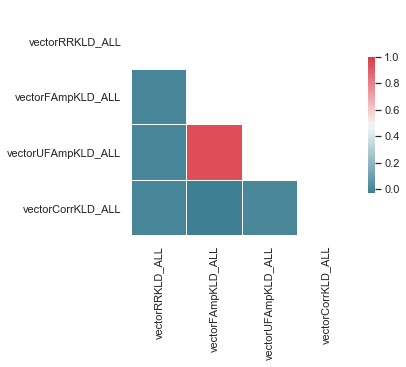

In [7]:
%matplotlib inline
dp.draw_correlation_matrix(df_ALL)

In [ ]:
sns.pairplot(df_ALL)

In [ ]:
plt.clf()
plt.close()

In [ ]:
#sns.jointplot(df_ALL['vectorFAmpKLD_ALL'], df_ALL['vectorRRKLD_ALL'], kind="kde")

## Outliers

In [8]:
len(df_ALL) - df_ALL.count()

vectorRRKLD_ALL          457
vectorFAmpKLD_ALL          0
vectorUFAmpKLD_ALL         0
vectorCorrKLD_ALL     550220
dtype: int64

In [9]:
num_attribs = list(df_ALL)

pipeline = Pipeline([
        ('selector', hp.DataFrameSelector(num_attribs)), # to handle pandas data frame
        ('imputer', Imputer(strategy="median")), # fill missing values with median
    ])

data_prepared = pipeline.fit_transform(df_ALL)
del pipeline

In [10]:
df_prepare = hp.convertDictInDF(hp.putDataInDict(
        [data_prepared[:,0], data_prepared[:,1], data_prepared[:,2], data_prepared[:,3]],
        ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD']
    ))
del data_prepared
df_prepare.describe()

,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
count,1.831859e+07,1.831859e+07,1.831859e+07,1.831859e+07
mean,1.161670e+05,6.841581e+01,8.901138e+01,9.657773e+00
std,2.485500e+08,4.143550e+02,4.064917e+02,1.278694e+01
min,-1.196758e+01,0.000000e+00,-1.520206e+00,0.000000e+00
25%,8.495514e+00,3.713773e+00,1.054000e+01,4.480612e+00
50%,1.112204e+01,5.402751e+00,1.454159e+01,7.082061e+00
75%,1.566994e+01,8.439792e+00,2.199167e+01,1.126715e+01
max,5.349180e+11,1.286997e+04,1.465847e+04,7.022134e+02


In [11]:
df_prepare.shape

(18318591, 4)

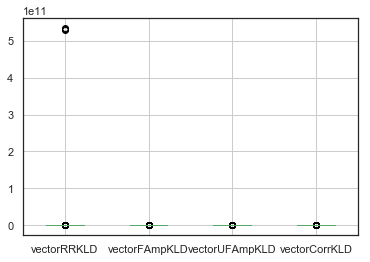

In [12]:
df_prepare.boxplot()

In [13]:
plt.clf()
plt.close()

In [14]:
df_o = df_prepare.copy()
del df_prepare, df_ALL
gc.collect()

3239

In [15]:
#df_o.boxplot(column='vectorCorrKLD')

In [16]:
z = np.abs(stats.zscore(df_o['vectorCorrKLD']))
threshold = 50
print(np.where(z > threshold))
df_o3 = df_o.copy()
df_o3 = df_o3[(z <= threshold)]
print(df_o3.shape)

(array([8954013, 8954014, 8954015, 8954016, 8954017, 8954018, 8954019,
       8954020, 8954023, 8954024, 8954025, 8954026, 8954027, 8954028,
       8954029, 8954030]),)
(18318575, 4)


In [17]:
z = np.abs(stats.zscore(df_o3['vectorRRKLD']))
threshold = 50
print(np.where(z > threshold))
df_o = df_o3.copy()
df_o = df_o[(z <= threshold)]
print(df_o.shape)

(array([203065, 203066, 203067, 203068]),)
(18318571, 4)


In [18]:
z = np.abs(stats.zscore(df_o['vectorFAmpKLD']))
threshold = 50
print(np.where(z > threshold))
df_o3 = df_o.copy()
df_o3 = df_o3[(z <= threshold)]
print(df_o3.shape)

(array([], dtype=int64),)
(18318571, 4)


In [19]:
z = np.abs(stats.zscore(df_o3['vectorUFAmpKLD']))
threshold = 50
print(np.where(z > threshold))
df_o = df_o3.copy()
df_o = df_o[(z <= threshold)]
print(df_o.shape)

(array([], dtype=int64),)
(18318571, 4)


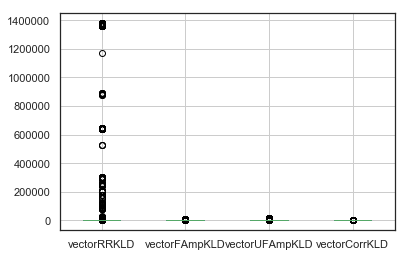

In [20]:
df_o.boxplot()

In [21]:
plt.clf()
plt.close()

In [22]:
len(df_o) - df_o.count()

vectorRRKLD       0
vectorFAmpKLD     0
vectorUFAmpKLD    0
vectorCorrKLD     0
dtype: int64

### Pre processing

In [23]:
df_final = df_o
del df_o

In [24]:
len(df_final) - df_final.count()

vectorRRKLD       0
vectorFAmpKLD     0
vectorUFAmpKLD    0
vectorCorrKLD     0
dtype: int64

In [25]:
num_attribs = list(df_final)

pipeline = Pipeline([
        ('selector', hp.DataFrameSelector(num_attribs)), # to handle pandas data frame
        ('imputer', Imputer(strategy="median")), # fill missing values with median
        ('std_scaler', StandardScaler())
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ("main", pipeline),
    ])

data_prepared = full_pipeline.fit_transform(df_final)

In [26]:
df_normalized = hp.convertDictInDF(hp.putDataInDict(
        [data_prepared[:,0], data_prepared[:,1], data_prepared[:,2], data_prepared[:,3]],
        ['vectorRRKLD_N', 'vectorFAmpKLD_N', 'vectorUFAmpKLD_N', 'vectorCorrKLD_N']
    ))
df_normalized.describe()

,vectorRRKLD_N,vectorFAmpKLD_N,vectorUFAmpKLD_N,vectorCorrKLD_N
count,1.831857e+07,1.831857e+07,1.831857e+07,1.831857e+07
mean,-2.786926e-19,1.207272e-16,-2.120934e-18,-2.143121e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.140969e-02,-1.651141e-01,-2.227136e-01,-7.561457e-01
25%,-4.844084e-03,-1.561513e-01,-1.930446e-01,-4.053195e-01
50%,-4.001361e-03,-1.520752e-01,-1.832005e-01,-2.016287e-01
75%,-2.542162e-03,-1.447456e-01,-1.648728e-01,1.260568e-01
max,4.439157e+02,3.089513e+01,3.584194e+01,4.894245e+01


In [27]:
del data_prepared, full_pipeline, pipeline

### PCA

>*[0.50219192 0.28210948 0.20605092 0.00964767]* : first 3 carries the most info with standarized data (95%)
>
>*[0.92169138 0.04827627 0.02278563 0.00724673]* : first 1 carries the most info without standarizing data
>
> This is how we know we should standarize since it permits the other 2 axes to participate

In [28]:
X = df_normalized

In [29]:
pca = PCA(n_components=0.95)
pca.fit(X)  
print(pca.explained_variance_ratio_) 
print(pca.singular_values_)
print(pca.components_)

[0.48507999 0.25297434 0.24707231]
[5961.86961398 4305.40514362 4254.88500434]
[[-5.04889913e-04  7.07136397e-01  7.06914755e-01 -1.51456393e-02]
 [ 7.04299801e-01 -2.50687259e-03  1.82152335e-02  7.09664506e-01]
 [ 7.09902482e-01  3.02996056e-03 -1.76086480e-02 -7.04073307e-01]]


In [30]:
X_New = pca.transform(X)
principalDf = pd.DataFrame(data=X_New, columns=['pc1', 'pc2', 'pc3'])

<IPython.core.display.Javascript object>


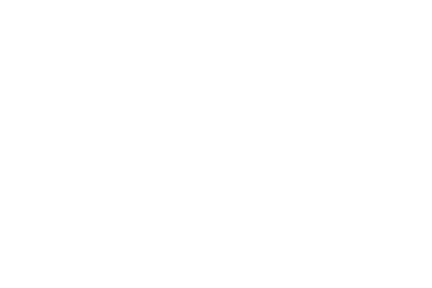

<IPython.core.display.Javascript object>


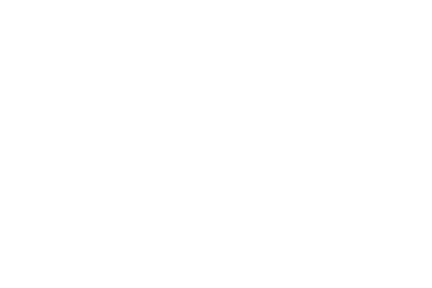

In [17]:
%matplotlib notebook
dp.print3dScatter(principalDf['pc1'], principalDf['pc2'], principalDf['pc3'])

<IPython.core.display.Javascript object>


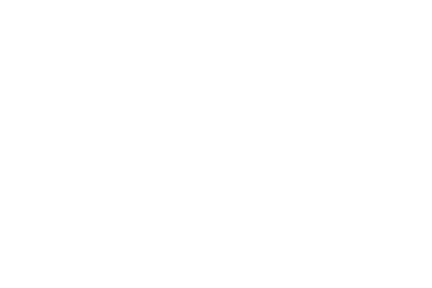

In [113]:
plt.clf()
plt.close()

In [31]:
%matplotlib inline

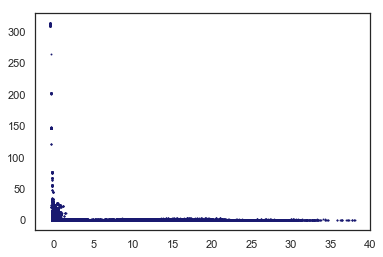

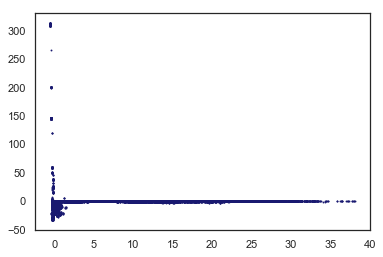

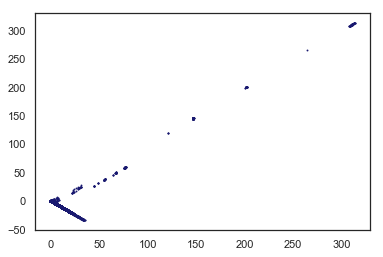

In [32]:
dp.printScatter(principalDf['pc1'], principalDf['pc2'])
dp.printScatter(principalDf['pc1'], principalDf['pc3'])
dp.printScatter(principalDf['pc2'], principalDf['pc3'])

In [33]:
titles = principalDf.columns.tolist()
principalDf.describe()

,pc1,pc2,pc3
count,1.831857e+07,1.831857e+07,1.831857e+07
mean,5.061693e-17,-1.221546e-16,1.276036e-16
std,1.392954e+00,1.005931e+00,9.941274e-01
min,-4.663095e-01,-5.455160e-01,-3.447696e+01
25%,-2.417226e-01,-2.920137e-01,-9.087574e-02
50%,-2.352973e-01,-1.405101e-01,1.340931e-01
75%,-2.223732e-01,8.790523e-02,2.834295e-01
max,3.805125e+01,3.138145e+02,3.139811e+02


## ------{ X to use }-----

In [34]:
X = X_New

## 1 Gaussian Mixture Model

https://scikit-learn.org/stable/unsupervised_learning.html


In [35]:
n_components_range = range(1, 7)
best_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range)

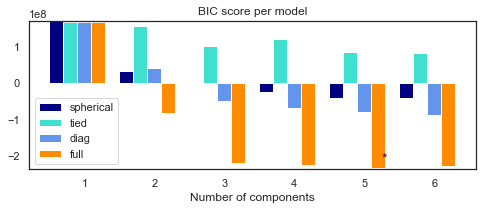

In [36]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange', 'gold', 'tomato'])
dp.plotBICScores(bic, cv_types, color_iter, n_components_range)

In [37]:
gmm = GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [49]:
best_gmm1, aic, cv_types2 = cl.getBestGMMUsingAIC(X, n_components_range)

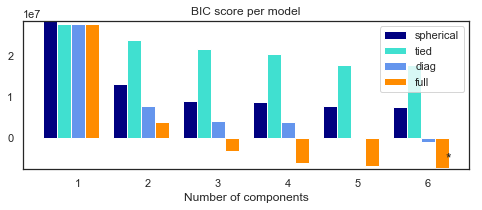

In [50]:
aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange', 'gold', 'tomato'])
dp.plotBICScores(aic, cv_types2, color_iter, n_components_range)

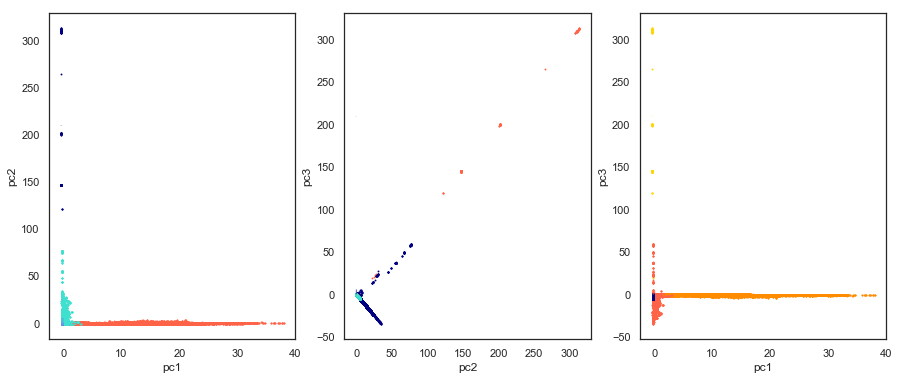

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.getPlotGMM(best_gmm, X, color_iter, 0, 1, ax[0], titles)
dp.getPlotGMM(best_gmm, X, color_iter, 1, 2, ax[1], titles)
dp.getPlotGMM(best_gmm, X, color_iter, 0, 2, ax[2], titles)
plt.show()
fig.clf()
plt.close()

In [39]:
hp.getRepresentativeness(best_gmm, X, best_gmm.predict(X))

{'>50': 1, '>30': 0, '>15': 0, '<15': 4}


[{'group': 0, 'qty': 14472641, 'representativeness': 0.7900529468155567},
 {'group': 1, 'qty': 2010498, 'representativeness': 0.10975190149930363},
 {'group': 2, 'qty': 174, 'representativeness': 9.498557502110836e-06},
 {'group': 3, 'qty': 187428, 'representativeness': 0.01023158411210132},
 {'group': 4, 'qty': 1647830, 'representativeness': 0.0899540690155362}]

In [40]:
del bic, best_gmm

## 2 K-Means

[2, 3, 4, 5] components

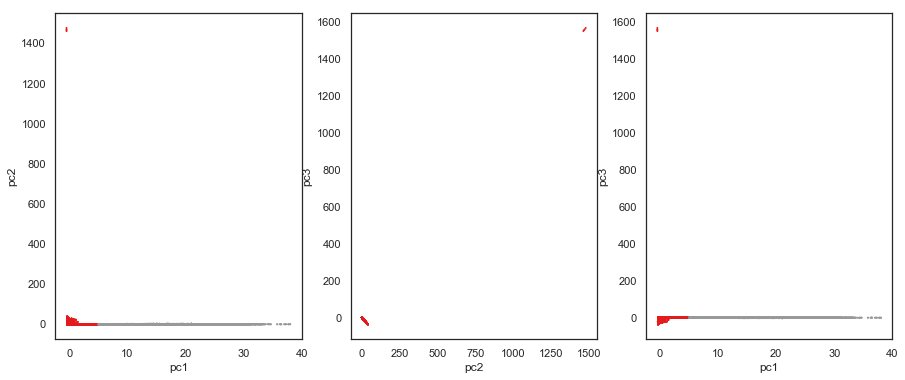

{'>50': 1, '>30': 0, '>15': 0, '<15': 1}
[{'group': 0, 'qty': 18031453, 'representativeness': 0.9843253228373295}, {'group': 1, 'qty': 287138, 'representativeness': 0.015674677162670427}]


In [27]:
Y_, km = cl.getKmeanskClusters(2, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))
del km, Y_
plt.clf()
plt.close()

In [28]:
importlib.reload(dp)

<module 'display' from '/homes/v18porti/Documents/code/imt_stg/display.py'>

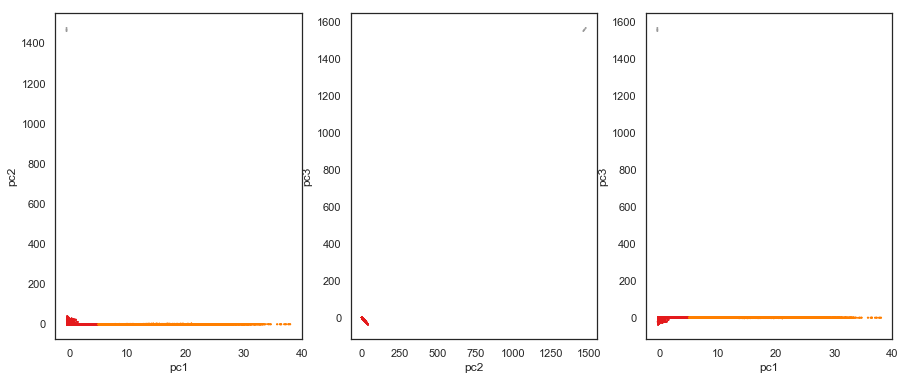

{'>50': 1, '>30': 0, '>15': 0, '<15': 2}
[{'group': 0, 'qty': 18031436, 'representativeness': 0.984324394818357}, {'group': 1, 'qty': 287151, 'representativeness': 0.015675386824237737}, {'group': 2, 'qty': 4, 'representativeness': 2.183574053266433e-07}]


In [29]:
Y_, km = cl.getKmeanskClusters(3, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))

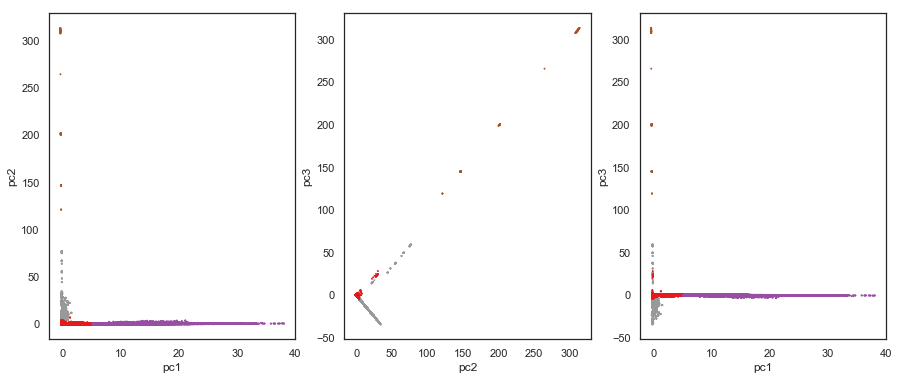

{'>50': 1, '>30': 0, '>15': 0, '<15': 3}
[{'group': 0, 'qty': 17963609, 'representativeness': 0.9806228335168721}, {'group': 1, 'qty': 287207, 'representativeness': 0.01567846094545257}, {'group': 2, 'qty': 170, 'representativeness': 9.28019985838415e-06}, {'group': 3, 'qty': 67585, 'representativeness': 0.003689425337817016}]


In [41]:
Y_, km = cl.getKmeanskClusters(4, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))

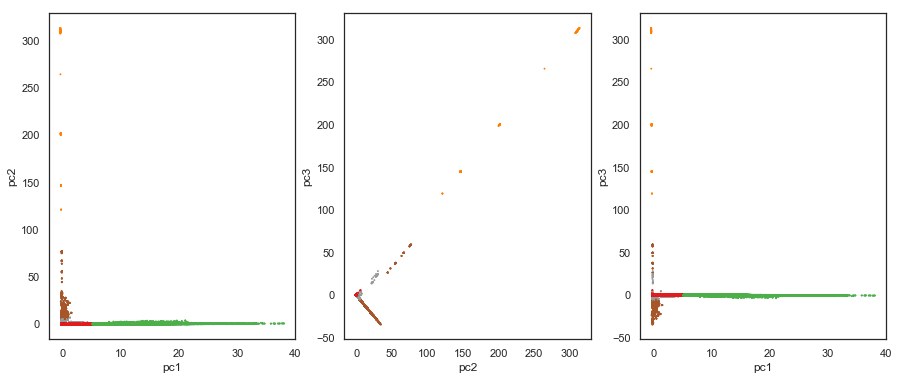

{'>50': 1, '>30': 0, '>15': 0, '<15': 4}
[{'group': 0, 'qty': 16220428, 'representativeness': 0.88546360957959}, {'group': 1, 'qty': 287012, 'representativeness': 0.01566781601032089}, {'group': 2, 'qty': 170, 'representativeness': 9.28019985838415e-06}, {'group': 3, 'qty': 48562, 'representativeness': 0.00265097097366383}, {'group': 4, 'qty': 1762399, 'representativeness': 0.09620832323656688}]


In [42]:
Y_, km = cl.getKmeanskClusters(5, X)
dp.printThreeKMaeans(X, Y_, titles)
print(hp.getRepresentativenessKM(km, X, Y_))

In [47]:
del Y_, km

## 3 Mean Shift
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

> Bandwidth is not very different with quantity of samples 50000 or 100000, so for ease of computation, we will use 50000.
> 
> Quantile, it increases  the value of the bandwith, 0.3, gets 1.76 with 7 components, 0.5, gets 2.26 with 4 components

In [43]:
bandwidth = estimate_bandwidth(X, n_samples=50000, quantile=0.3)
bandwidth

0.6179432909833603

In [44]:
bandwidth2 = estimate_bandwidth(X, n_samples=50000, quantile=0.5)
bandwidth2

0.7641788592716269

In [45]:
bandwidth3 = estimate_bandwidth(X, n_samples=50000, quantile=0.7)
bandwidth3

0.9621823761467492

In [46]:
bandwidth4 = estimate_bandwidth(X, n_samples=50000, quantile=0.2)
bandwidth4

0.5369616060821741

number of estimated clusters : 89
{'>50': 1, '>30': 0, '>15': 0, '<15': 88}
[{'group': 0, 'qty': 17408561, 'representativeness': 0.9503230901580696}, {'group': 1, 'qty': 195821, 'representativeness': 0.01068975303805084}, {'group': 2, 'qty': 159494, 'representativeness': 0.00870668350713601}, {'group': 3, 'qty': 50553, 'representativeness': 0.002759658490828788}, {'group': 4, 'qty': 10569, 'representativeness': 0.0005769554841368357}, {'group': 5, 'qty': 5636, 'representativeness': 0.0003076659200109004}, {'group': 6, 'qty': 6410, 'representativeness': 0.0003499181240720141}, {'group': 7, 'qty': 3476, 'representativeness': 0.00018975279239849004}, {'group': 8, 'qty': 6572, 'representativeness': 0.0003587616086429449}, {'group': 9, 'qty': 1108, 'representativeness': 6.048506731229199e-05}, {'group': 10, 'qty': 814, 'representativeness': 4.443578049838058e-05}, {'group': 11, 'qty': 937, 'representativeness': 5.115027804297617e-05}, {'group': 12, 'qty': 431, 'representativeness': 2.352803

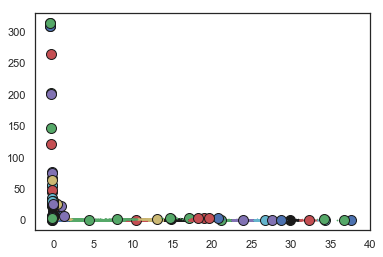

In [48]:
ms, n_clusters_, cluster_centers, labels = cl.meanClustering(X, bandwidth2)
print(hp.getRepresentativenessKM(ms, X, ms.predict(X)))
dp.plotMSh(X, ms, n_clusters_, cluster_centers, labels)

number of estimated clusters : 67
{'>50': 1, '>30': 0, '>15': 0, '<15': 66}
[{'group': 0, 'qty': 17265543, 'representativeness': 0.9425158217854439}, {'group': 1, 'qty': 196602, 'representativeness': 0.010732387367988474}, {'group': 2, 'qty': 173632, 'representativeness': 0.009478468598887981}, {'group': 3, 'qty': 49460, 'representativeness': 0.002699992264680471}, {'group': 4, 'qty': 10486, 'representativeness': 0.000572424563029507}, {'group': 5, 'qty': 5661, 'representativeness': 0.0003090306552841922}, {'group': 6, 'qty': 6393, 'representativeness': 0.0003489901040861757}, {'group': 7, 'qty': 3617, 'representativeness': 0.00019744989933985572}, {'group': 8, 'qty': 1716, 'representativeness': 9.367542915874824e-05}, {'group': 9, 'qty': 351, 'representativeness': 1.9160883237016686e-05}, {'group': 10, 'qty': 633, 'representativeness': 3.455509711974804e-05}, {'group': 11, 'qty': 654, 'representativeness': 3.570147474931314e-05}, {'group': 12, 'qty': 372, 'representativeness': 2.03072

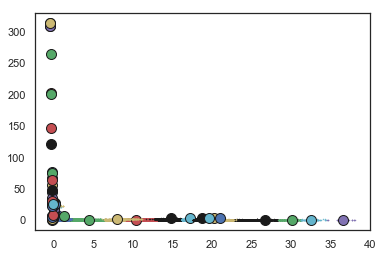

In [49]:
ms1, n_clusters_1, cluster_centers1, labels1 = cl.meanClustering(X, bandwidth3)
print(hp.getRepresentativenessKM(ms1, X, ms1.predict(X)))
dp.plotMSh(X, ms1, n_clusters_1, cluster_centers1, labels1)

## 4 Variational Bayesian Gaussian Mixture

Having 5 components, changig the n_init, it has a better distribution in "representativeness" with a value of 2 and max_iter = 200

/usr/lib/python3/dist-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 2 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


{'>50': 1, '>30': 0, '>15': 1, '<15': 3}
[{'group': 0, 'qty': 13412233, 'representativeness': 0.7321650993790952}, {'group': 1, 'qty': 1149758, 'representativeness': 0.06276454340838769}, {'group': 2, 'qty': 70989, 'representativeness': 0.00387524346168327}, {'group': 3, 'qty': 2874740, 'representativeness': 0.15693019184717863}, {'group': 4, 'qty': 810871, 'representativeness': 0.04426492190365514}]


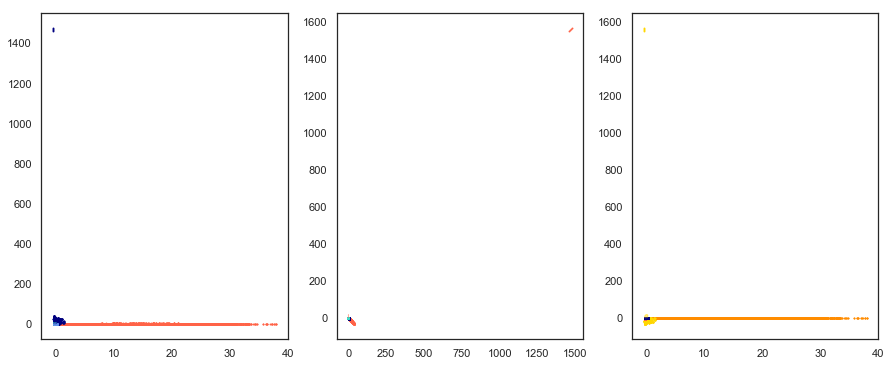

In [36]:
dpgmm1 = BayesianGaussianMixture(n_components=5,
                                max_iter=200, n_init=2,
                                covariance_type='full').fit(X)
#print(dpgmm1.means_)
#print(dpgmm1.covariances_)
Y_ = dpgmm1.predict(X)
print(hp.getRepresentativeness(dpgmm1, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm1.means_, dpgmm1.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

/usr/lib/python3/dist-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 2 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


{'>50': 1, '>30': 0, '>15': 0, '<15': 4}
[{'group': 0, 'qty': 1265946, 'representativeness': 0.0691071709609107}, {'group': 1, 'qty': 1447279, 'representativeness': 0.07900602180593475}, {'group': 2, 'qty': 14879475, 'representativeness': 0.8122608884056639}, {'group': 3, 'qty': 2704, 'representativeness': 0.00014760960600081088}, {'group': 4, 'qty': 723187, 'representativeness': 0.039478309221489795}]


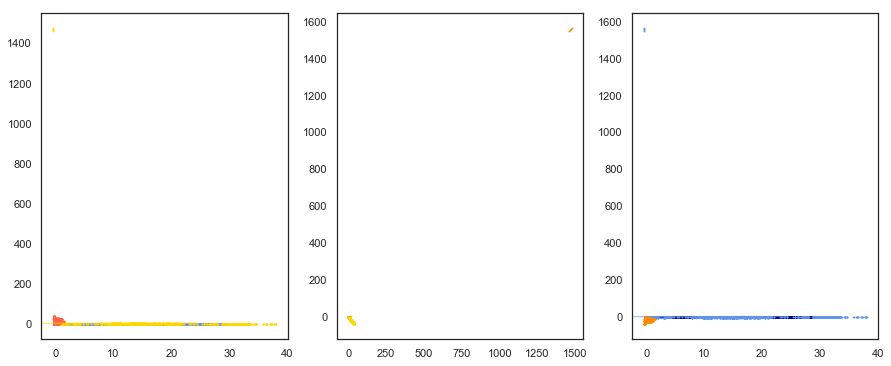

In [37]:
dpgmm2 = BayesianGaussianMixture(n_components=5,
                                max_iter=100, n_init=2,
                                covariance_type='full').fit(X)
#print(dpgmm2.means_)
#print(dpgmm2.covariances_)
Y_ = dpgmm2.predict(X)
print(hp.getRepresentativeness(dpgmm2, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm2.means_, dpgmm2.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm2.means_, dpgmm2.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm2.means_, dpgmm2.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

/usr/lib/python3/dist-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


{'>50': 1, '>30': 0, '>15': 1, '<15': 3}
[{'group': 0, 'qty': 810920, 'representativeness': 0.044267596781870394}, {'group': 1, 'qty': 1149672, 'representativeness': 0.06275984872417316}, {'group': 2, 'qty': 13411660, 'representativeness': 0.7321338196807822}, {'group': 3, 'qty': 70992, 'representativeness': 0.0038754072297372652}, {'group': 4, 'qty': 2875347, 'representativeness': 0.15696332758343695}]


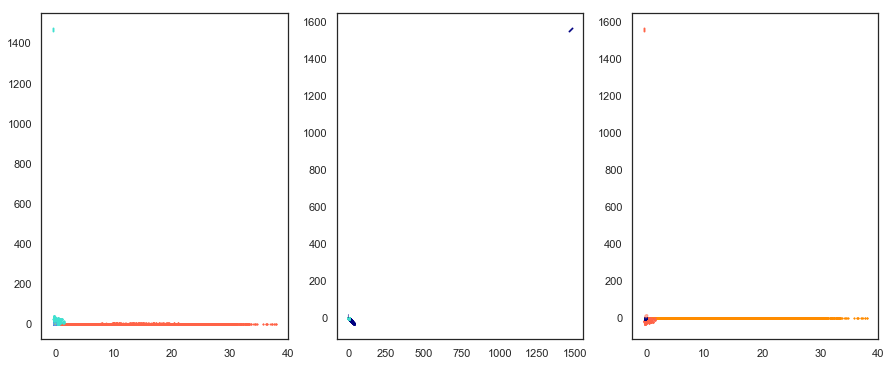

In [38]:
dpgmm3 = BayesianGaussianMixture(n_components=5,
                                max_iter=200,
                                covariance_type='full').fit(X)
#print(dpgmm3.means_)
#print(dpgmm3.covariances_)
Y_ = dpgmm3.predict(X)
print(hp.getRepresentativeness(dpgmm3, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm3.means_, dpgmm3.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

/usr/lib/python3/dist-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


{'>50': 1, '>30': 0, '>15': 0, '<15': 4}
[{'group': 0, 'qty': 1265930, 'representativeness': 0.06910629753128938}, {'group': 1, 'qty': 1447271, 'representativeness': 0.0790055850911241}, {'group': 2, 'qty': 2704, 'representativeness': 0.00014760960600081088}, {'group': 3, 'qty': 723185, 'representativeness': 0.03947820004278713}, {'group': 4, 'qty': 14879501, 'representativeness': 0.8122623077287986}]


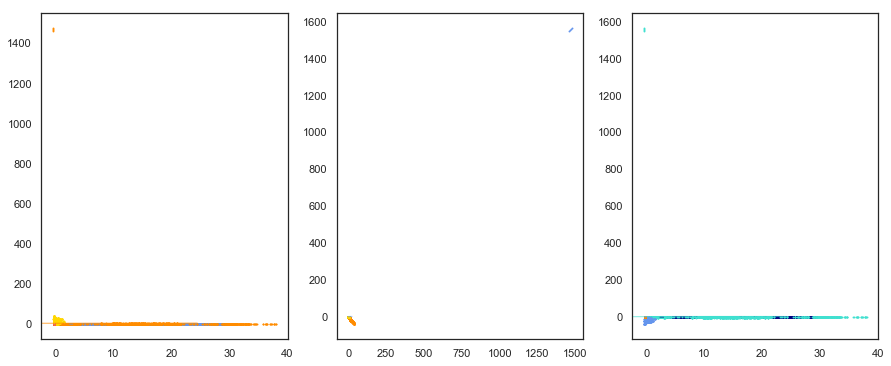

In [39]:
dpgmm4 = BayesianGaussianMixture(n_components=5,
                                max_iter=100,
                                covariance_type='full').fit(X)
#print(dpgmm4.means_)
#print(dpgmm4.covariances_)
Y_ = dpgmm4.predict(X)
print(hp.getRepresentativeness(dpgmm4, X, Y_))
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
dp.plotGM(X, Y_, dpgmm4.means_, dpgmm4.covariances_, ax[0], 0, 1, color_iter)
dp.plotGM(X, Y_, dpgmm4.means_, dpgmm4.covariances_, ax[1], 1, 2, color_iter)
dp.plotGM(X, Y_, dpgmm4.means_, dpgmm4.covariances_, ax[2], 0, 2, color_iter)
plt.show()
fig.clf()
plt.close()

In [ ]:
# modify n_jobs maybe???,,